23rd October 2025

##### Prerequisites

In [1]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
import scipy, pickle
import scipy.signal
from tqdm import tqdm
from scipy import ndimage


In [2]:
# Constants
epsilon = 1e-10

#### Supporting Functions

##### Data extraction

In [3]:
def get_input_data(activation_path, trajectory_path):
    with open(trajectory_path, 'rb') as f:
        data_pos = pickle.load(f)

    with open(activation_path, 'rb') as f:
        activations = pickle.load(f)

    #data_pos['x'][0],data_pos['x'][0] = -0.7,-0.7
    x = np.asarray(data_pos['x'])
    y = np.asarray(data_pos['y'])
    positions = np.column_stack((x, y))
    return positions, activations

##### Plotting functions

In [4]:
def plot_activations_vs_position(activations, positions, layer_name):
    """
    Plots neuron activations for each layer against position.

    Parameters:
    activations: list of tensors containing neuron activations for specific layer
    positions: numpy array of shape (time_steps, 1), containing positions at each timestep
    """

    x_axis = positions[:, 0]

    num_neurons = activations.shape[1]
    #num_neurons = 1

    num_rows = 10
    num_cols = 5

    plt.figure(figsize=(20, 2 * num_rows))
    plt.suptitle(f'Amplitude vs Position for Layer: {layer_name}', fontsize=16)

    for neuron_index in range(num_neurons):
        plt.subplot(num_rows, num_cols, neuron_index + 1)
        plt.plot(x_axis, activations[:, neuron_index], color = "green")
        #plt.plot(x_axis_rest, activations[500:1000, neuron_index], color = "red")
        #plt.plot(x_axis_backward, activations[1000:1500, neuron_index], color = "orange")
        plt.xlabel('Position')
        plt.ylabel('Amplitude')
        plt.title(f'Neuron {neuron_index + 1}')
        #plt.ylim(global_min, global_max)  # Adjust as per the range of activation values

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [5]:
def plot_frm_vs_position(frm, positions, layer_name, res_param=40):
    """
    Plots firing rate map of neurons in given layer vs position.

    Parameters:
    frm: Firing rate map of each neuron in given layer
    positions: numpy array of shape (time_steps, 1), containing positions at each timestep
    reso: Resolution used for the histogram
    """
    x = np.linspace(positions[:,0].min(), positions[:,0].max(), res_param*2)

    num_neurons = activations.shape[1]

    num_rows = 30
    num_cols = 5

    plt.figure(figsize=(20, 2 * num_rows))
    plt.suptitle(f'Firing rate vs Position for Layer: {layer_name}', fontsize=16)

    for neuron_index in range(num_neurons):
        plt.subplot(num_rows, num_cols, neuron_index + 1)
        plt.scatter(x, frm[neuron_index])
        plt.xlabel('Position')
        plt.ylabel('Firing rate')
        plt.title(f'Neuron {neuron_index + 1}')
        #plt.ylim(global_min, global_max)  # Adjust as per the range of activation values

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return x

##### Maps

In [6]:
# Occupancy Map for 1D track - to get position_probability - P(x)

def occupancy_map_func(pos, reso=40, win_len=9):
    '''
    Calculate Occupancy map
    pos: 1D array of positions (track points)
    reso: Resolution for the histogram
    win_len: Window length for the Gaussian filter
    '''

    H1, _ = np.histogram(pos, bins=reso*2)

    gaussian = np.exp(-0.5 * (np.linspace(-3, 3, win_len) ** 2))
    gaussian = gaussian / np.sum(gaussian)

    pos_prob = np.convolve(H1, gaussian, mode='same')
    pos_prob = pos_prob / np.nansum(pos_prob)

    pos_prob[pos_prob == 0] = np.nan

    return pos_prob


In [7]:
def firing_rate_map(resp_neurons, positions, occupancy_map, thresh_param=0.0, title="", ticks_colbar=None, res_param=40, sub_plot=False):
    '''
    Getting Firing rate map from activation and position data, and occupancy map -> No. of spike counts or activation in occupancy time
    '''
    x_positions = positions[:, 0]

    # Computing baseline firing threshold
    mean_resp = np.mean(resp_neurons)
    std_resp = np.std(resp_neurons)
    thresh = mean_resp + (thresh_param * std_resp)

    # Selecting neurons that are firing above the threshold
    firr = np.nonzero(resp_neurons > thresh)
    firposgrid = x_positions[firr[0]]  # Extracting positions of neurons that have fired above the computedthreshold

    # Creating a 1D grid
    x = np.linspace(positions[:,0].min(), positions[:,0].max(), res_param*2)
    firingmap = np.zeros(len(x))

    # Assigning the firing values at the corresponding positions on the track
    firingvalue = resp_neurons[firr]
    for ii in range(len(firposgrid)):
        # Finding the closest grid point on the 1D track using absolute difference
        q1 = np.argmin(np.abs(firposgrid[ii] - x))
        firingmap[q1] = max(firingvalue[ii], firingmap[q1])  # Keep the max firing rate at each position

    # Normalizing the firing map by the occupancy map (time spent in each region)
    if len(occupancy_map) != len(x):
        # Interpolate occupancy map to match the resolution of the firing map
        occupancy_map_interp = np.interp(x, np.linspace(0, 1, len(occupancy_map)), occupancy_map)
    else:
        occupancy_map_interp = occupancy_map

    occupancy_map_interp = np.where(occupancy_map_interp == 0, np.nan, occupancy_map_interp)

    # Normalize firing map by occupancy
    firingmap = firingmap / occupancy_map_interp

    # Applying 1D Gaussian smoothing
    win_len = 9  # Length of Gaussian window
    gaussian = np.exp(-0.5 * (np.linspace(-3, 3, win_len) ** 2))  # 1D Gaussian kernel
    gaussian = gaussian / np.sum(gaussian)  # Normalize the kernel

    # Smoothening the firing map using the Gaussian kernel
    firingmap_smooth = np.convolve(firingmap, gaussian, mode='same')
    firingmap_norm = np.array([1 + (99 * (value - firingmap_smooth.min()) / (firingmap_smooth.max() - firingmap_smooth.min() + epsilon)) for value in firingmap_smooth])
    # Plotting the firing rate map
    if not sub_plot:
        plt.plot(x, firingmap_smooth, label='Firing Rate')
        plt.title(title)
        plt.xlabel('Position along 1D track')
        plt.ylabel('Firing Rate')
        plt.colorbar(ticks=ticks_colbar)
        plt.show()

    return firingmap_smooth, firingmap_norm, firposgrid


##### Scores

In [8]:
def inf_rate(rate_map, px):
    '''
    Calculating spatial information rate - bytes/ spike
    rate_map: firing rate map
    px: occupancy map
    '''
    tmp_map = np.ma.array(rate_map, copy=True)
    tmp_map[np.isnan(tmp_map)] = 0
    avg_rate = np.sum(np.ravel(tmp_map * px))

    #return (np.nansum(np.ravel(tmp_map * np.log2(tmp_map/avg_rate) * px)),
    #        avg_rate)

    return (np.nansum(np.ravel((tmp_map/avg_rate) * np.log2(np.maximum(tmp_map/avg_rate, epsilon)) * px)),
            avg_rate)

In [9]:
def sparsity_func(pos_prob, firing_rate):
    '''
    Calculating sparsity for a given firing rate map

    input:
    pos_prob: probability matrix for position - from occupancy map
    firing_rate: rate map

    output: sparsity from the paper
    '''
    px = np.copy(pos_prob)
    pos_prob2 = px/(np.nansum(px) + epsilon)

    avg_rate = np.nansum(np.ravel(firing_rate * pos_prob2))
    numerator = avg_rate ** 2
    denominator = np.nansum(np.multiply(pos_prob2, firing_rate**2)) + epsilon
    return numerator/denominator

In [10]:
def get_scores(positions, activations):
    '''
    Calculating sparsity,  spatial information rate and spatial score
    '''

    global lim, reso
    sparsity_scores = []
    spatial_info = []
    occupancy_map = occupancy_map_func(positions)
    num_neurons = activations.shape[1]
    fpg_allN = []
    fm_allN = []
    for i in range(num_neurons):
        resp_neurons = activations[:, i]

        fr_map, fr_norm, firposgrid = firing_rate_map(resp_neurons, positions, occupancy_map=occupancy_map, thresh_param=lim, res_param = reso, sub_plot=True)
        fm_allN.append(fr_norm)
        fpg_allN.append(firposgrid)
        # Calculating spatial info
        sp_info_rate, avg_rate = inf_rate(fr_map, occupancy_map)
        #spatial_information = sp_info_rate*0.1/avg_rate
        spatial_information = sp_info_rate/avg_rate
        if np.ma.is_masked(spatial_information):
            spatial_information = 0  # Replace masked value with 0 or any other default value you prefer
        else:
            spatial_information = round(spatial_information,2)
        spatial_info.append(spatial_information)


        # Calculating sparsity scores
        sparsity_score = sparsity_func(occupancy_map, fr_map)
        if np.ma.is_masked(sparsity_score):
            sparsity_score = 0  # Replace masked value with 0 or any other default value you prefer
        else:
            sparsity_score = round(sparsity_score,2)
        sparsity_scores.append(sparsity_score)

    return spatial_info, sparsity_scores, fpg_allN, fm_allN

##### Extracting place cells

In [10]:
def identify_place_cells(spatial_info, sparsity_scores, positions, activations):


    selected_neus_spainfo = np.where(np.asarray(spatial_info) > spi_threshold)[0]
    print(f"Neurons selected wrt spatial_info: ", selected_neus_spainfo)

    selected_neus_spars = np.where(np.asarray(sparsity_scores) < spar_threshold)[0]
    print(f"Neurons selected wrt to sparsity: ", selected_neus_spars)

    selected_neus = list(set(selected_neus_spars) & set(selected_neus_spainfo))
    print(f"Neurons satisfying both criteria: ", np.array(selected_neus))

    place_cells = selected_neus

    return place_cells


In [11]:
def get_scores_by_place_cells(place_cells, spatial_info, sparsity_scores):
    '''
    Extracts spatial information and sparsity scores for identified place cells.

    Args:
        place_cells (list): A list of indices representing the identified place cells.
        spatial_info (list): A list of spatial information scores for all neurons.
        sparsity_scores (list): A list of sparsity scores for all neurons.

    Returns:
        dict: A dictionary containing the place cell indices, spatial information scores,
              and sparsity scores for the selected place cells.
    '''

    place_cells_indices = []
    place_cells_spatial = []
    place_cells_sparsity = []

    for i in place_cells:
        place_cells_indices.append(i)  # Corrected indexing
        place_cells_spatial.append(spatial_info[i])  # Corrected indexing
        place_cells_sparsity.append(sparsity_scores[i])  # Corrected indexing

    pc_dict = {
        'place_cells_indices': place_cells_indices,
        'spatial_info': place_cells_spatial,
        'sparsity_scores': place_cells_sparsity
    }

    return pc_dict


### Identifying place cells

#### Input data extraction

In [12]:
# Get input data

#activation_path_complex = 'input_data/activations/donn_v2/activations_15secfrb_detuned_traj5_osc3_complex.pkl'
#activation_path_abs = 'input_data/activations/donn_v2/activations_15secfrb_detuned_traj5_osc3_abs.pkl'

activation_path_abs = 'z3_activations.pkl'
activation_path_complex = 'z3_activations.pkl'
trajectory_path = 'trajectory_data.pkl'

In [13]:
reso = 40
lim = 1.8

positions, activations = get_input_data(activation_path_abs, trajectory_path)

In [17]:
# Reduce to 50 neurons
activations = activations[:, :50]

In [18]:
print(positions.shape)
print(activations.shape)

(1000, 2)
(1000, 50)


In [19]:
layer_name = 'Osc 3'

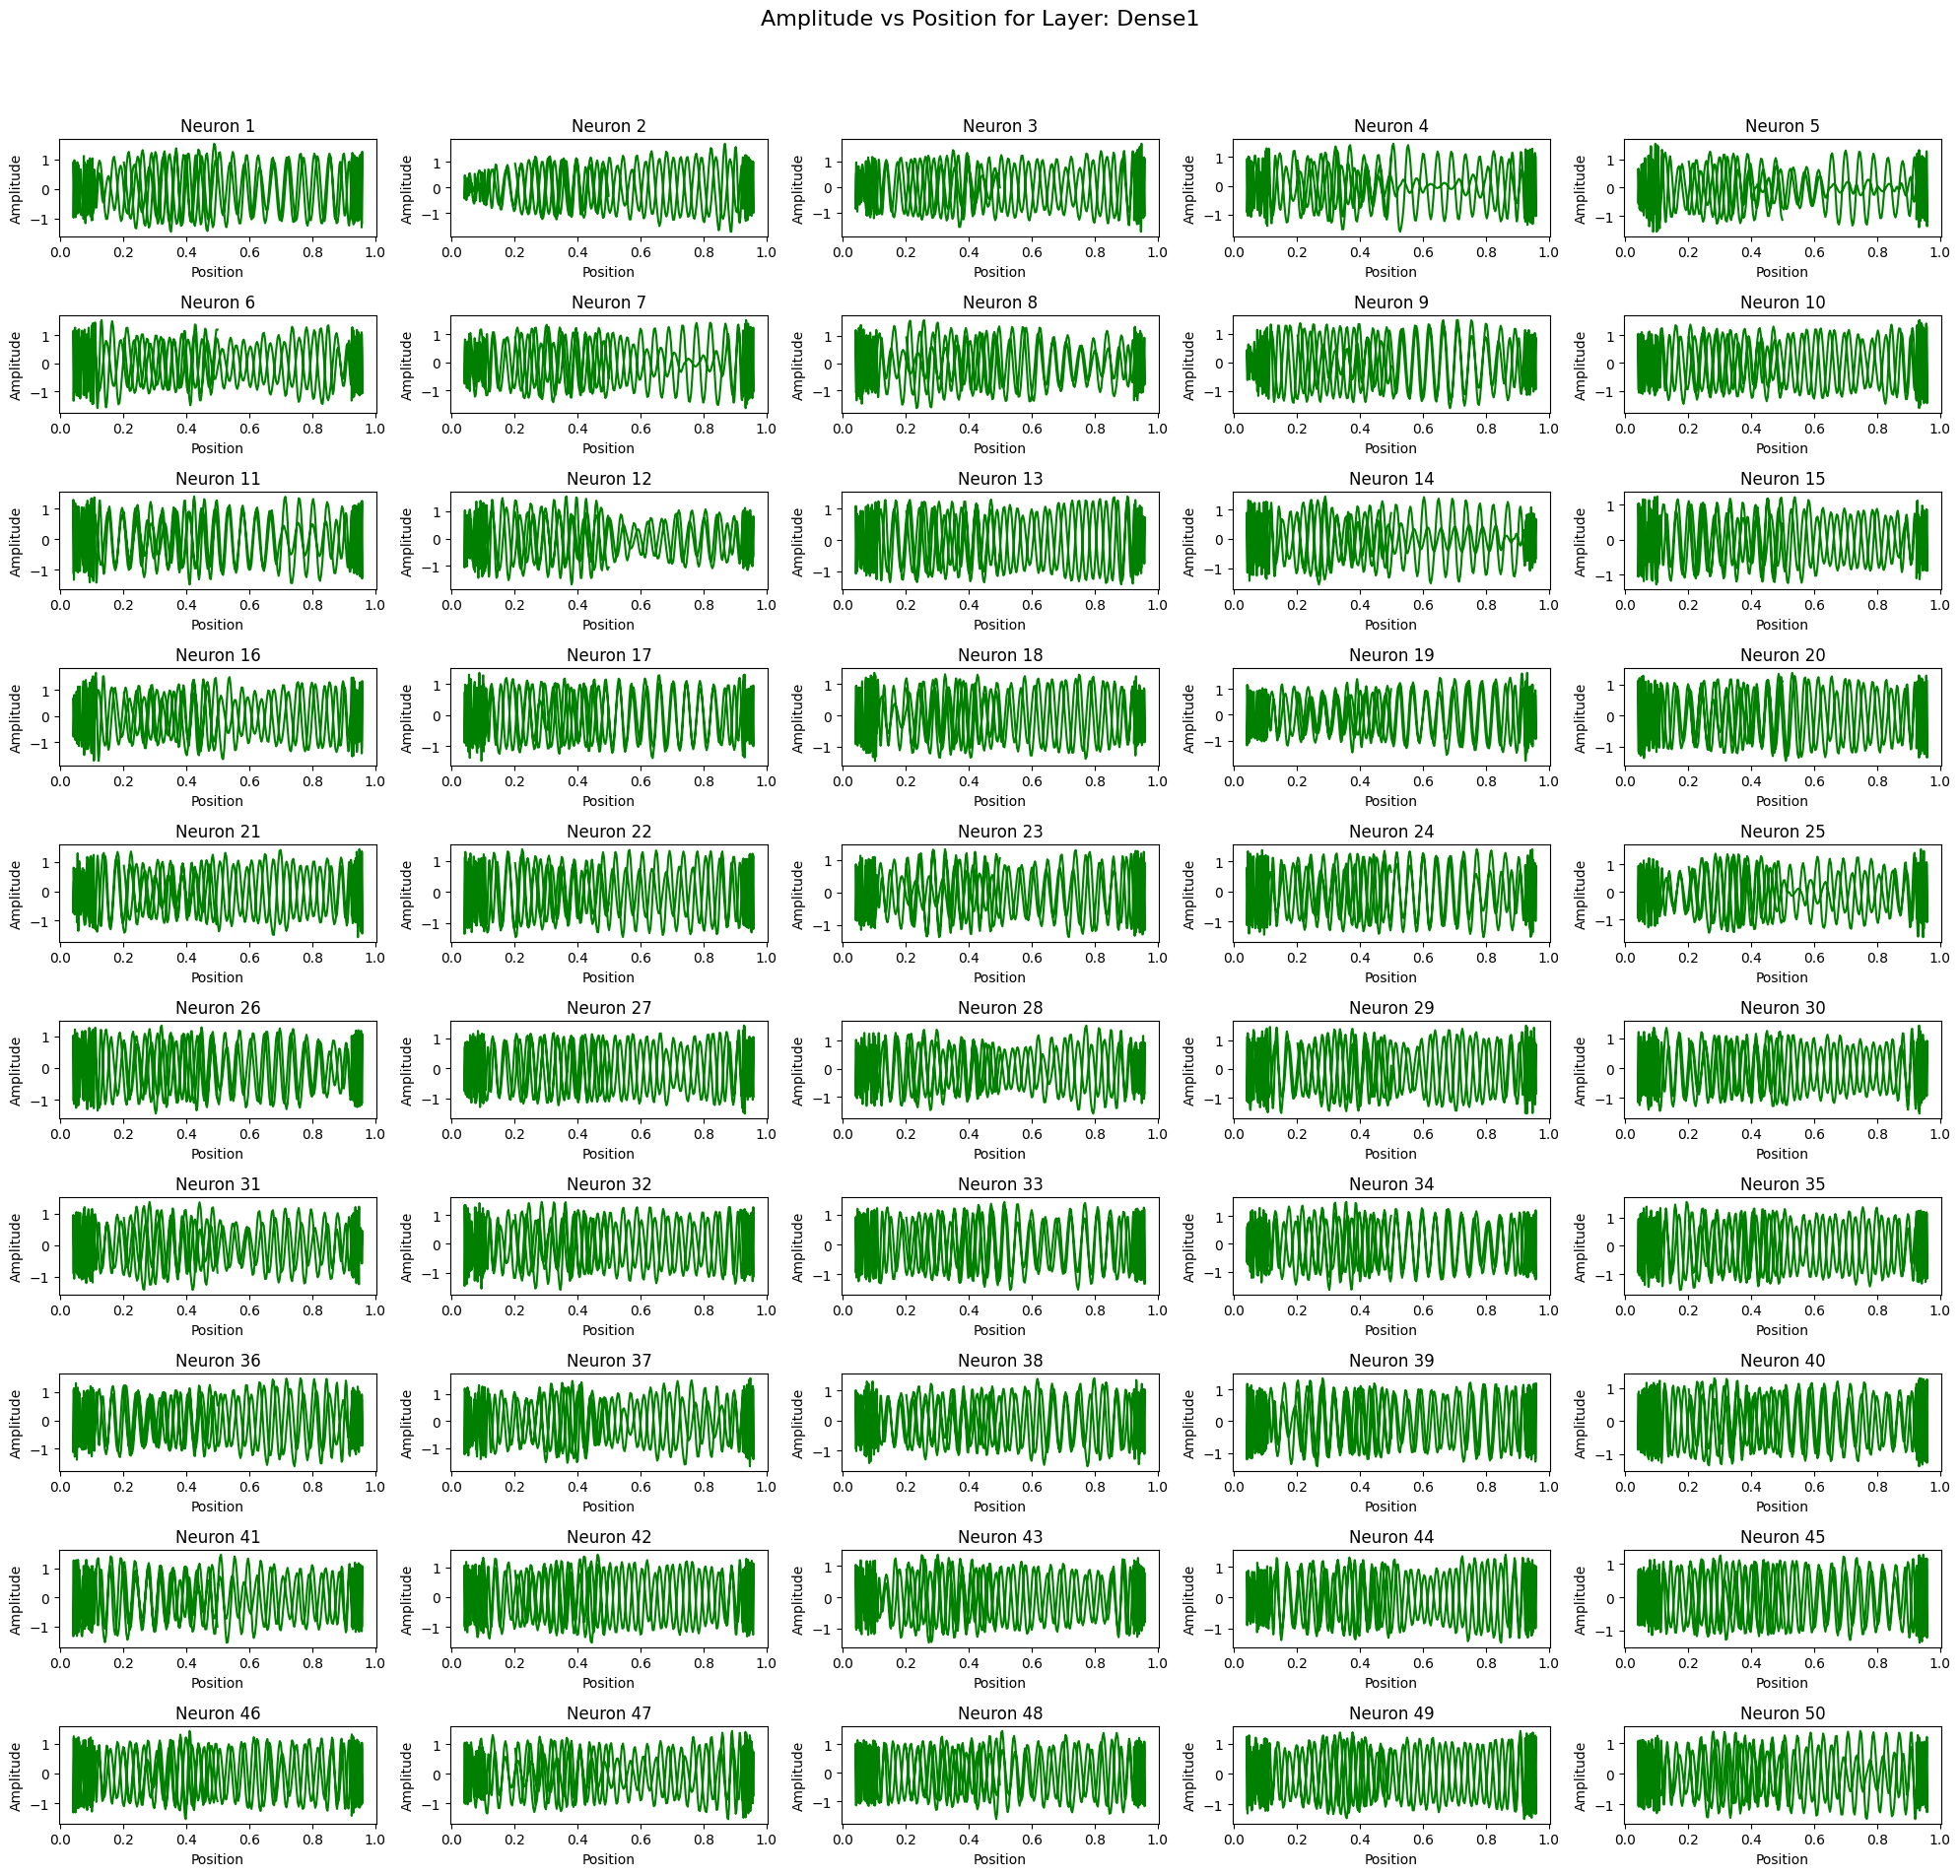

In [20]:
plot_activations_vs_position(activations, positions, layer_name='Dense1')

#### Calculate spatial_info and sparsity

In [21]:
epsilon = 1e-10
spatial_info, sparsity_scores, fpgrid, frm = get_scores(positions, activations)

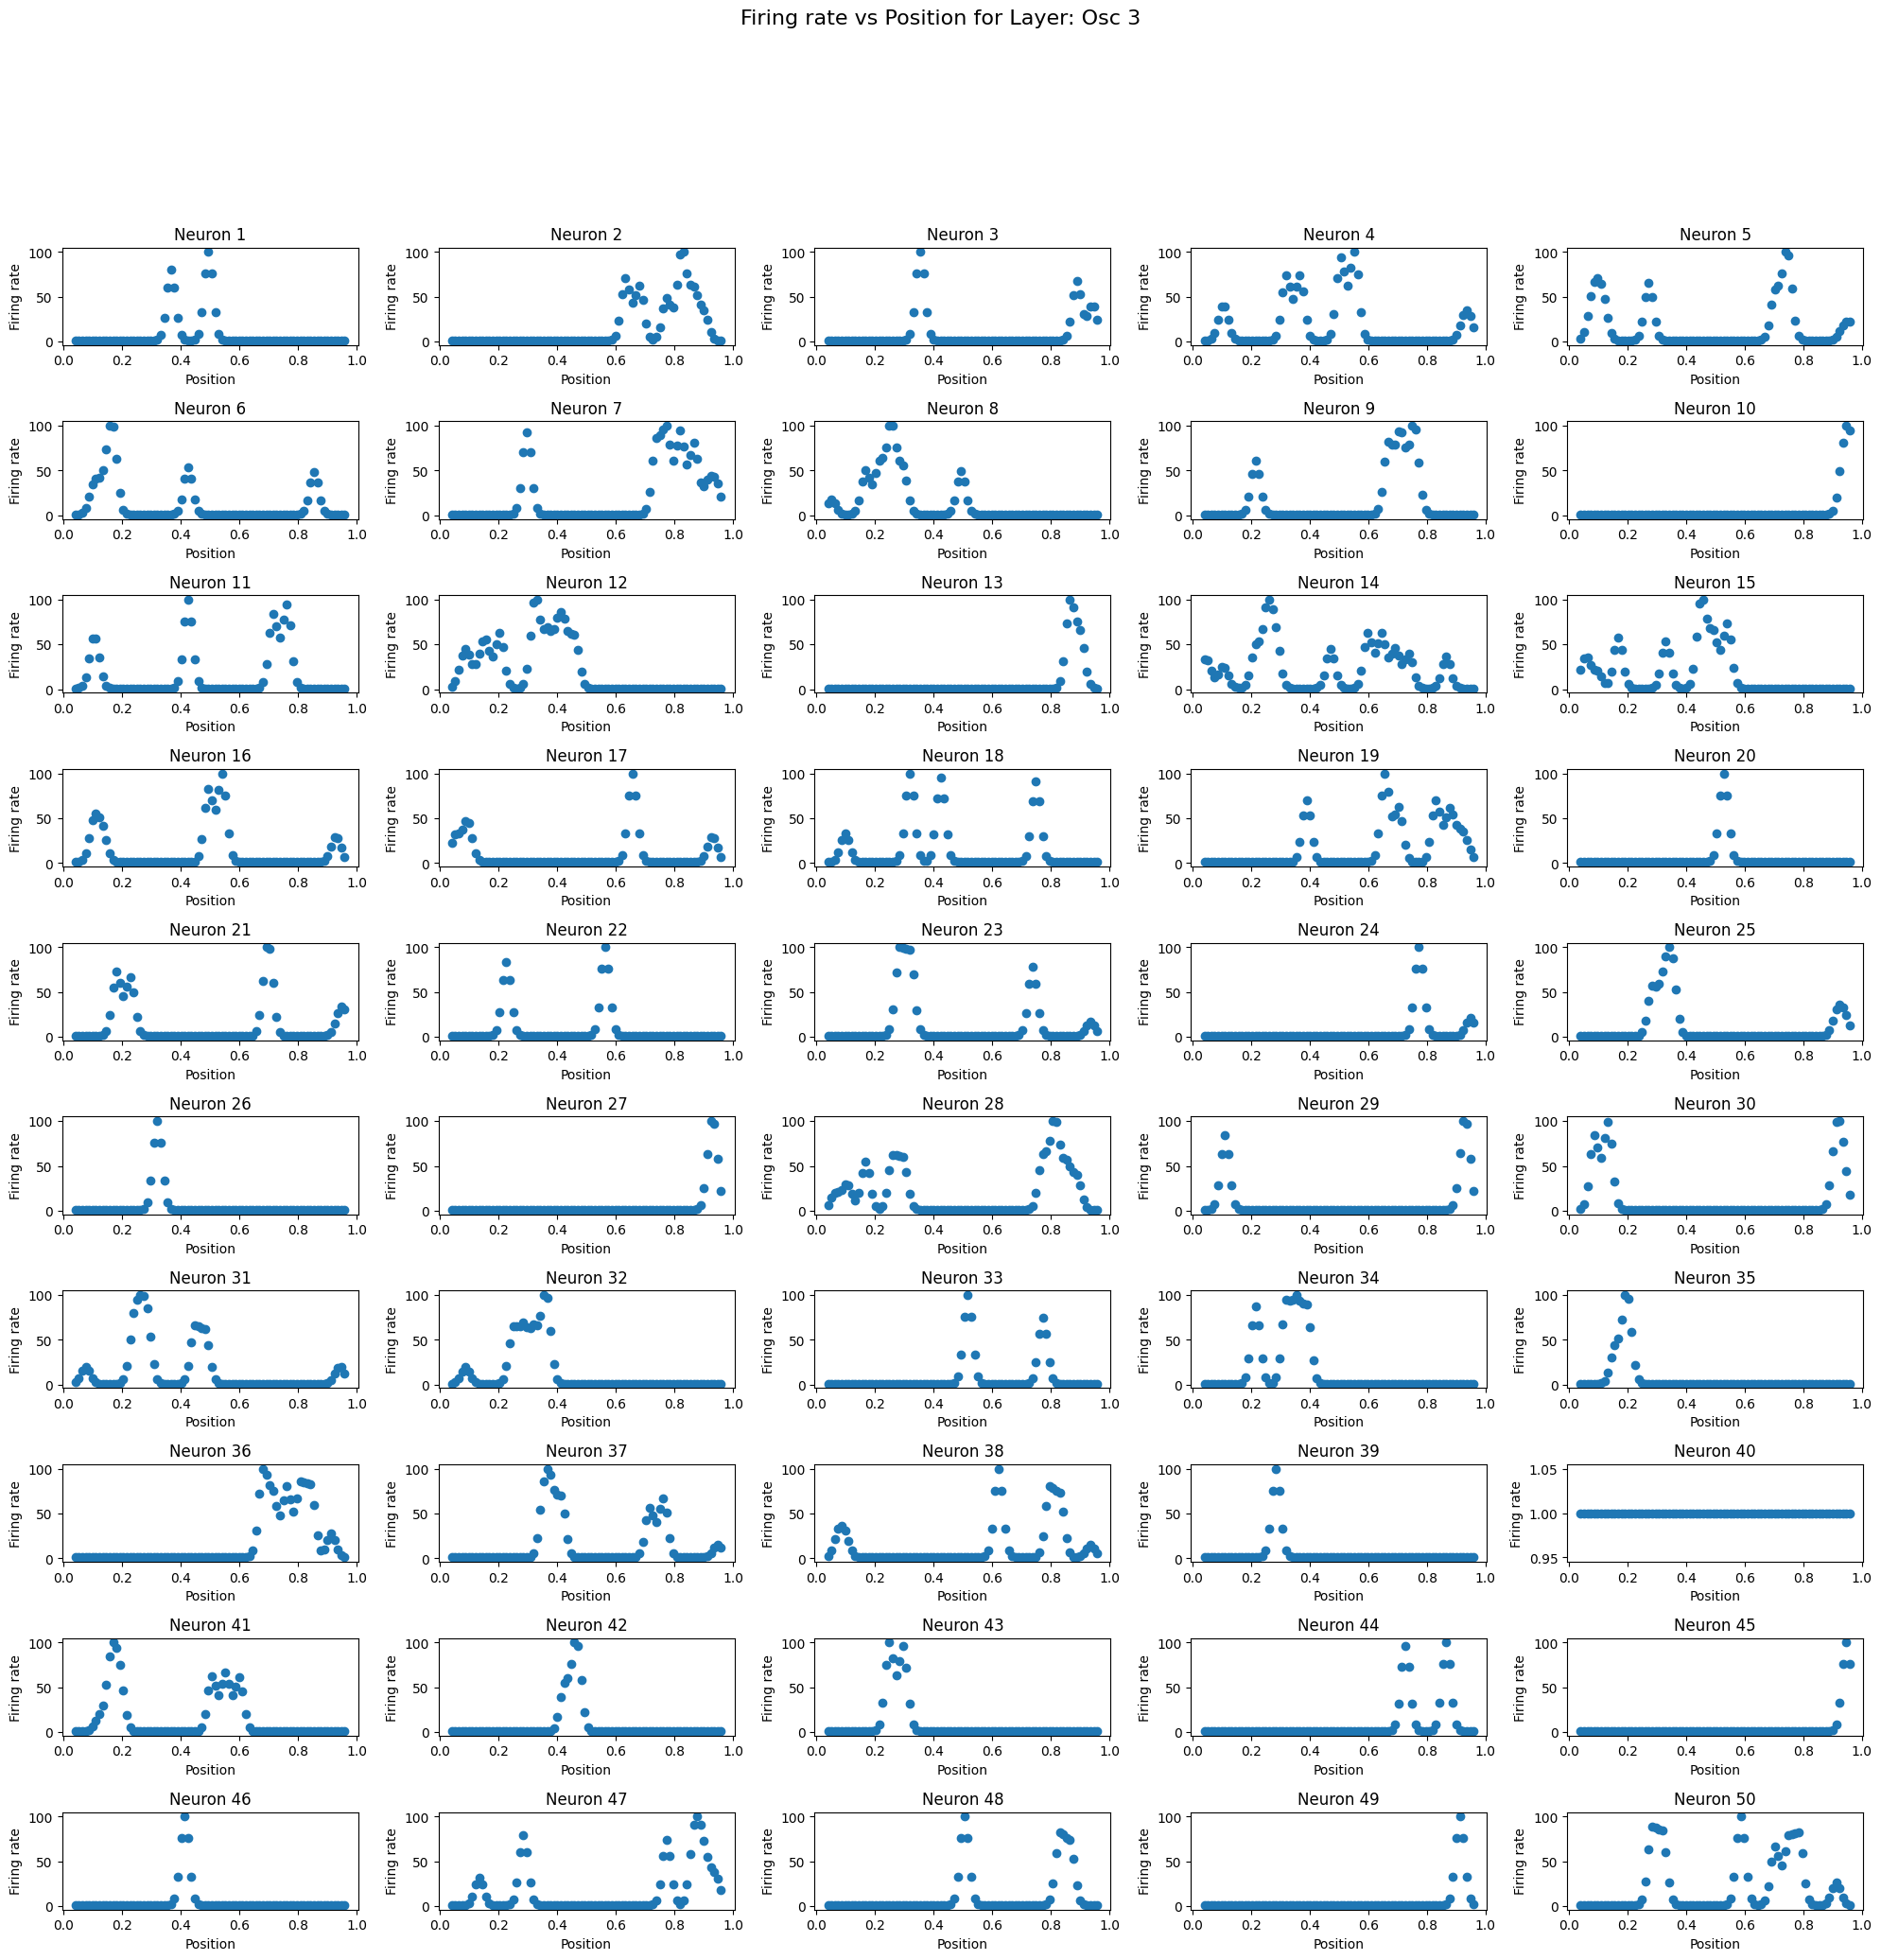

In [22]:
position_bins = plot_frm_vs_position(frm, positions, layer_name, reso)

In [23]:
specific_locations = position_bins[frm[19] > 1]

In [24]:
print(specific_locations)

[0.48248343 0.49409861 0.50571379 0.51732897 0.52894415 0.54055933
 0.5521745  0.56378968 0.57540486]


In [25]:
def plot_frm_vs_position_single(frm, positions, layer_name, res_param=40):
    """
    Plots firing rate maps of all neurons in a single plot vs position.
    """
    positions = np.array(positions)  # Ensure it's a NumPy array
    x = np.linspace(positions.min(), positions.max(), frm.shape[1])
    num_neurons = frm.shape[0]

    plt.figure(figsize=(10, 6))
    for neuron_index in range(num_neurons):
        plt.plot(x, frm[neuron_index], label=f'Neuron {neuron_index + 1}', alpha=0.7)

    plt.title(f'Firing Rate vs. Position — Layer: {layer_name}', fontsize=14)
    plt.xlabel('Position')
    plt.ylabel('Firing Rate')
    if num_neurons <= 20:
        plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [26]:
print(f"Info Rate of all neurons: ", np.array(spatial_info))
print("="*50)
print(f"Sparsity Scores of all neurons: ", np.array(sparsity_scores))

Info Rate of all neurons:  [1.2  0.18 0.32 0.1  0.08 0.18 0.13 0.2  0.32 1.03 0.28 0.08 0.92 0.06
 0.14 0.13 0.18 0.36 0.14 3.33 0.21 1.32 0.43 1.01 0.17 3.23 0.97 0.07
 0.41 0.25 0.16 0.27 1.2  0.48 0.73 0.22 0.23 0.18 3.27 0.   0.21 0.9
 1.36 1.11 2.57 3.04 0.12 0.69 1.77 0.17]
Sparsity Scores of all neurons:  [0.08 0.22 0.25 0.38 0.38 0.24 0.35 0.19 0.14 0.17 0.25 0.36 0.12 0.41
 0.3  0.33 0.34 0.21 0.33 0.03 0.24 0.07 0.17 0.12 0.23 0.04 0.17 0.37
 0.29 0.38 0.25 0.17 0.08 0.13 0.07 0.23 0.21 0.28 0.04 0.   0.19 0.07
 0.07 0.1  0.15 0.04 0.36 0.11 0.13 0.27]


#### Identify place cells w. constraints:
Spatial Information Rate > 0.3 bits/spike

Sparsity Score < 0.1

In [27]:
spi_threshold = 0.3
spar_threshold = 0.1
place_cells = identify_place_cells(spatial_info, sparsity_scores, positions, activations)


Neurons selected wrt spatial_info:  [ 0  2  8  9 12 17 19 21 22 23 25 26 28 32 33 34 38 41 42 43 44 45 47 48]
Neurons selected wrt to sparsity:  [ 0 19 21 25 32 34 38 39 41 42 45]
Neurons satisfying both criteria:  [ 0 32 34 38 41 42 45 19 21 25]


In [28]:
print(len(place_cells))

10


In [29]:
place_cell_dict = get_scores_by_place_cells(place_cells, spatial_info, sparsity_scores)

In [30]:
for key, value in place_cell_dict.items():
    print(f"{key}:")
    print(value)
    print("-" * 50)  # Separator for better readability

place_cells_indices:
[np.int64(0), np.int64(32), np.int64(34), np.int64(38), np.int64(41), np.int64(42), np.int64(45), np.int64(19), np.int64(21), np.int64(25)]
--------------------------------------------------
spatial_info:
[np.float64(1.2), np.float64(1.2), np.float64(0.73), np.float64(3.27), np.float64(0.9), np.float64(1.36), np.float64(3.04), np.float64(3.33), np.float64(1.32), np.float64(3.23)]
--------------------------------------------------
sparsity_scores:
[np.float64(0.08), np.float64(0.08), np.float64(0.07), np.float64(0.04), np.float64(0.07), np.float64(0.07), np.float64(0.04), np.float64(0.03), np.float64(0.07), np.float64(0.04)]
--------------------------------------------------


In [31]:
print(place_cells)

[np.int64(0), np.int64(32), np.int64(34), np.int64(38), np.int64(41), np.int64(42), np.int64(45), np.int64(19), np.int64(21), np.int64(25)]


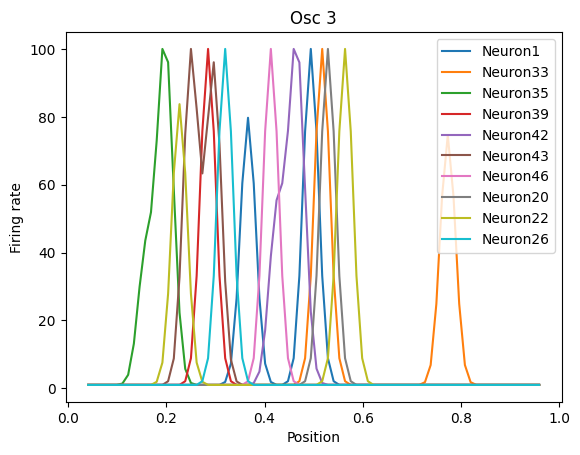

In [32]:
place_cells = np.array(place_cells)
'''
place_cell_activations = []
for i in place_cells:
    place_cell_activations.append(activations[:, i])

place_cell_activations = np.array(place_cell_activations)
place_cell_activations = place_cell_activations.reshape(200, 7)
print(place_cell_activations.shape)
'''
def plot_frm_vs_position_together(frm, forward_positions, layer_name, res_param=40):
    """
    Plots firing rate map of neurons in given layer vs position.

    Parameters:
    frm: Firing rate map of each neuron in given layer
    positions: numpy array of shape (time_steps, 1), containing positions at each timestep
    reso: Resolution used for the histogram
    """
    x = np.linspace(forward_positions[:,0].min(), forward_positions[:,0].max(), res_param*2)

    num_neurons = place_cells.shape[0]

    # num_rows = 30
    # num_cols = 5

    # plt.figure(figsize=(20, 2 * num_rows))
    # plt.suptitle(f'Firing rate vs Position for Layer: {layer_name}', fontsize=16)

    for i, neuron_index in enumerate(place_cells):
        #plt.plot(num_rows, num_cols, i+1)
        plt.plot(x, frm[neuron_index], label=f'Neuron{neuron_index+1}')
    plt.xlabel('Position')
    plt.ylabel('Firing rate')
    plt.title(layer_name)
        
    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.legend(loc='upper right')
    plt.show()
        #plt.ylim(global_min, global_max)  # Adjust as per the range of activation values
    

plot_frm_vs_position_together(frm, positions, layer_name, reso)

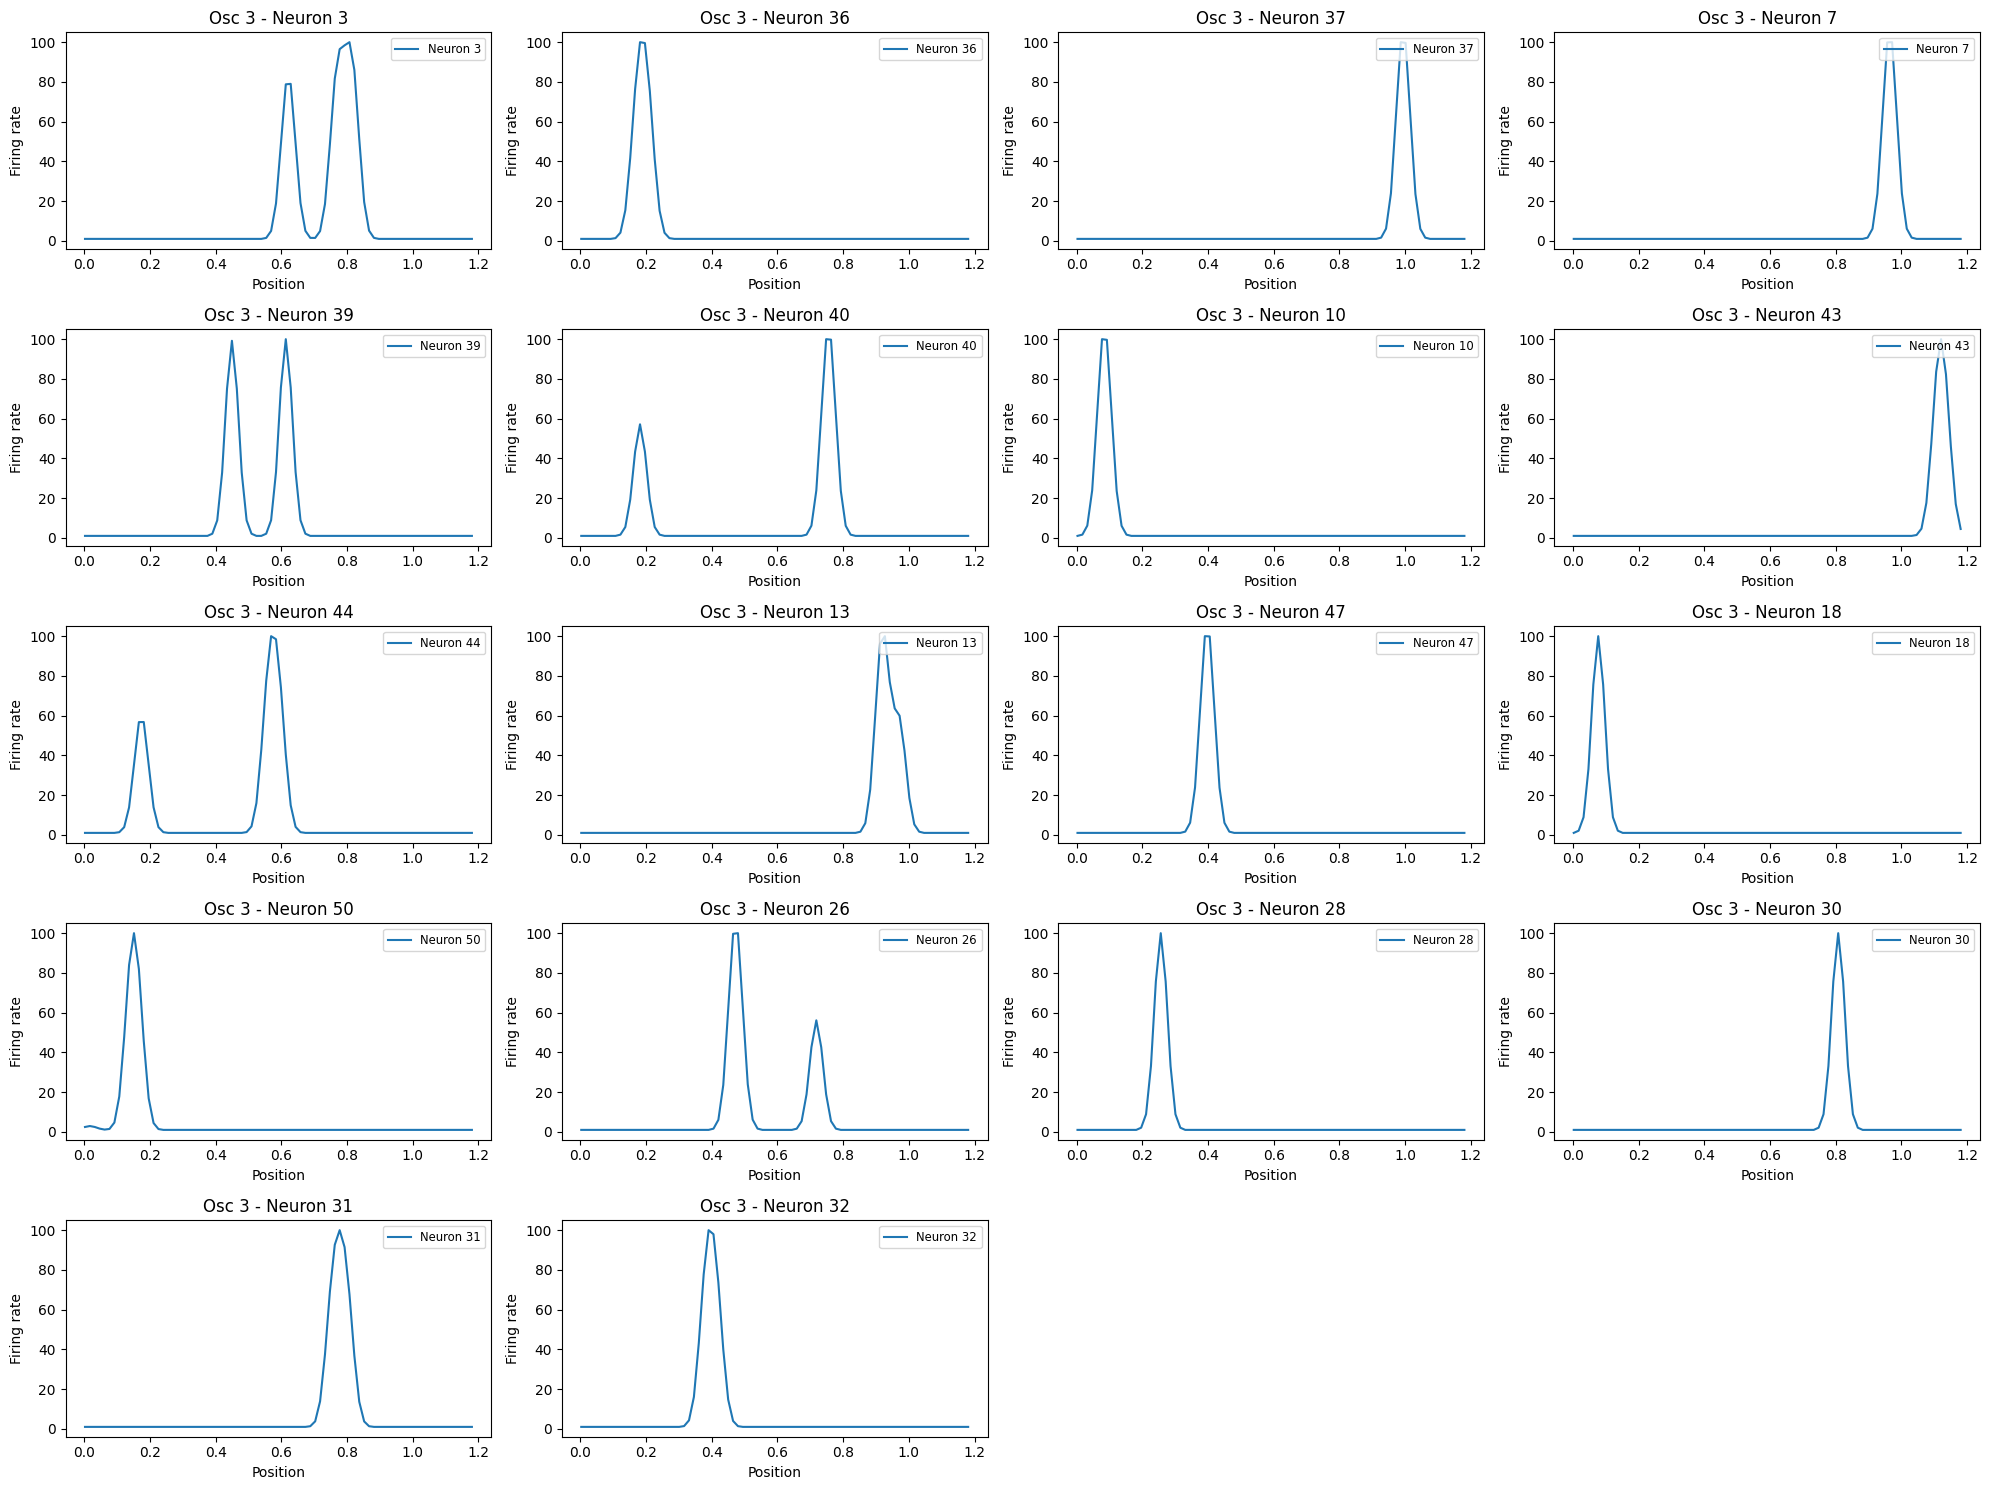

In [ ]:


place_cells = np.array(place_cells)
'''
place_cell_activations = []
for i in place_cells:
    place_cell_activations.append(activations[:, i])

place_cell_activations = np.array(place_cell_activations)
place_cell_activations = place_cell_activations.reshape(200, 7)
print(place_cell_activations.shape)
'''
def plot_frm_vs_position_together(frm, forward_positions, layer_name, res_param=40):
    """
    Plots firing rate map of neurons in given layer vs position.

    Parameters:
    frm: Firing rate map of each neuron in given layer
    positions: numpy array of shape (time_steps, 1), containing positions at each timestep
    reso: Resolution used for the histogram
    """
    x = np.linspace(forward_positions[:,0].min(), forward_positions[:,0].max(), res_param*2)

    num_neurons = place_cells.shape[0]

    # num_rows = 30
    # num_cols = 5

    # plt.figure(figsize=(20, 2 * num_rows))
    # plt.suptitle(f'Firing rate vs Position for Layer: {layer_name}', fontsize=16)

    for i, neuron_index in enumerate(place_cells):
        #plt.plot(num_rows, num_cols, i+1)
        plt.plot(x, frm[neuron_index], label=f'Neuron{neuron_index+1}')
    plt.xlabel('Position')
    plt.ylabel('Firing rate')
    plt.title(layer_name)
        
    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.legend(loc='upper right')
    plt.show()
        #plt.ylim(global_min, global_max)  # Adjust as per the range of activation values
    

plot_frm_vs_position_together(frm, positions, layer_name, reso)